In [37]:
#load libraries
library(ggplot2)
library("speedyseq")
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(vegan)
library("lubridate")
library('PCAtools')
library("DESeq2")
library("GGally")
library("ggpmisc")
library(patchwork)
library(ggtext)
library("ggcorrplot")
library("ggplotify")
library(microViz)
library(qiime2R)
library("MicrobiomeStat")
library("pairwiseAdonis"); packageVersion("pairwiseAdonis")
library(ggsignif)

[1] ‘0.4.1’

In [40]:
packageVersion("phyloseq")
packageVersion("Vegan")
packageVersion("pairwiseAdonis")

[1] ‘1.46.0’

[1] ‘2.6.4’

[1] ‘0.4.1’

In [2]:
#read metadata file and set factor order
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta, n=2)
dim(meta)

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 360  32

In [3]:
#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)
dim(ASV_table)


,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

In [4]:
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [5]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
ps %>% tax_fix()


#filter to remove noise from data
ps_fill = filter_taxa(ps, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill 

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2041 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 2041 taxa by 9 taxonomic ranks ]:
taxa are rows

In [6]:
# Subset samples healthy and then by species
ps_AH <- subset_samples(ps, Sample.Type=="Healthy")

ps_ah_DSTO=subset_samples(ps_AH, Species_sample=="DSTO")
ps_ah_DSTO
ps_ah_SINT=subset_samples(ps_AH, Species_sample=="SINT")
ps_ah_SINT
ps_ah_MCAV=subset_samples(ps_AH, Species_sample=="MCAV")
ps_ah_MCAV
ps_ah_OFAV=subset_samples(ps_AH, Species_sample=="OFAV")
ps_ah_OFAV
ps_ah_PSTR=subset_samples(ps_AH, Species_sample=="PSTR")
ps_ah_PSTR

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [7]:
#filter coral species to remove ASVs in low prevelenace 
ps_fill_dsto = filter_taxa(ps_ah_DSTO, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_dsto
ps_fill_sint = filter_taxa(ps_ah_SINT, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_sint
ps_fill_mcav = filter_taxa(ps_ah_MCAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_mcav
ps_fill_ofav = filter_taxa(ps_ah_OFAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_ofav               
ps_fill_pstr = filter_taxa(ps_ah_PSTR, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_pstr                           

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1427 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1427 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2016 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 2016 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 535 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 535 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 805 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 805 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1222 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1222 taxa by 9 taxonomic ranks ]:
taxa are rows

In [8]:
#transform each to normalize data using center log ratio
ps_clr_dsto <- microbiome::transform(ps_fill_dsto, 'clr')
ps_clr_sint <- microbiome::transform(ps_fill_sint, 'clr')
ps_clr_mcav <- microbiome::transform(ps_fill_mcav, 'clr')
ps_clr_ofav <- microbiome::transform(ps_fill_ofav, 'clr')
ps_clr_pstr <- microbiome::transform(ps_fill_pstr, 'clr')

In [9]:
# ordinate each transformation for PCA
ps_clr_dst_ord <- ordinate(ps_clr_dsto, "RDA", "euclidean")
ps_clr_sint_ord <- ordinate(ps_clr_sint, "RDA", "euclidean")
ps_clr_mcav_ord <- ordinate(ps_clr_mcav, "RDA", "euclidean")
ps_clr_ofav_ord <- ordinate(ps_clr_ofav, "RDA", "euclidean")
ps_clr_pstr_ord <- ordinate(ps_clr_pstr, "RDA", "euclidean")

In [10]:
cbPalette <- c( "#009E73","#D55E00","#696969")

In [11]:
ps_merge= merge_phyloseq(ps_clr_dsto,ps_clr_mcav, ps_clr_ofav, ps_clr_pstr, ps_clr_sint)

In [12]:
ps_merge= merge_phyloseq(ps_fill_dsto,ps_fill_sint, ps_fill_mcav, ps_fill_ofav, ps_fill_pstr)

In [13]:
ps_merge_clr = microbiome::transform(ps_merge, 'clr')

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”


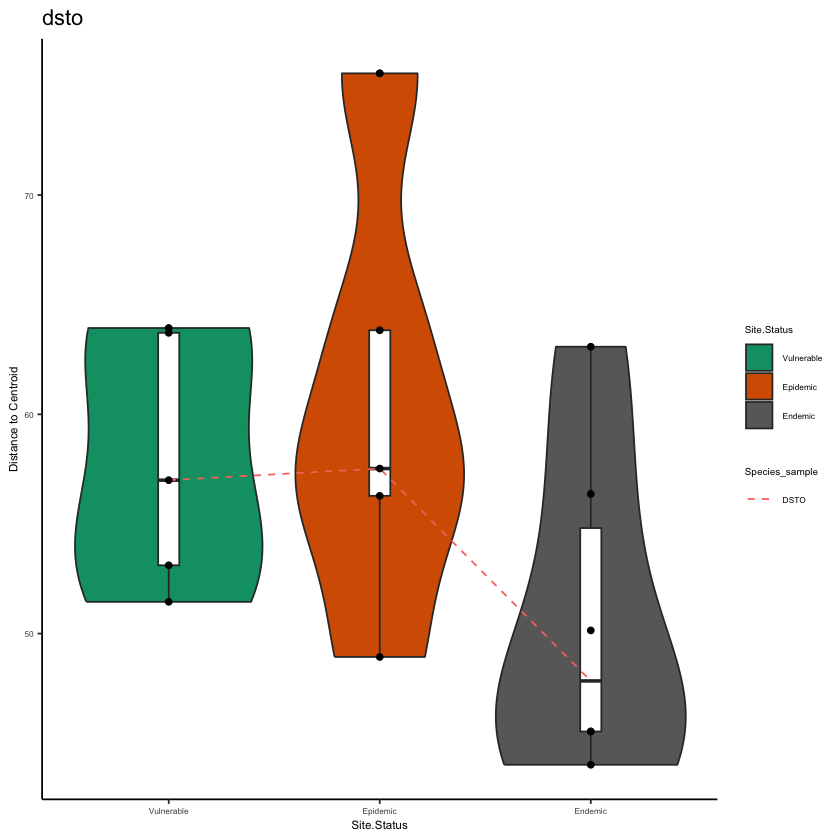

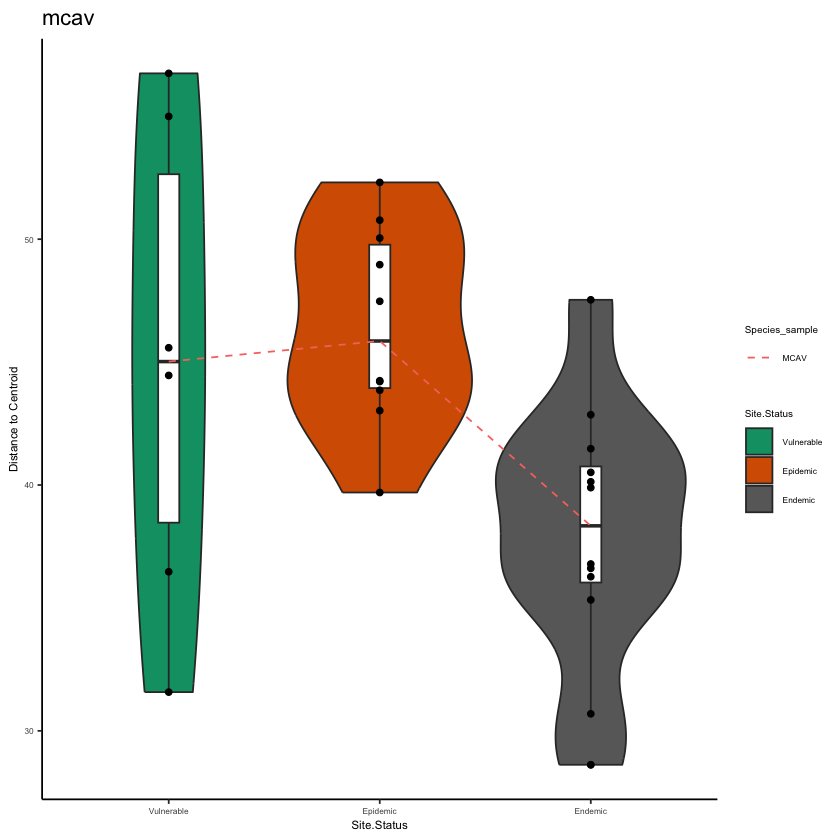

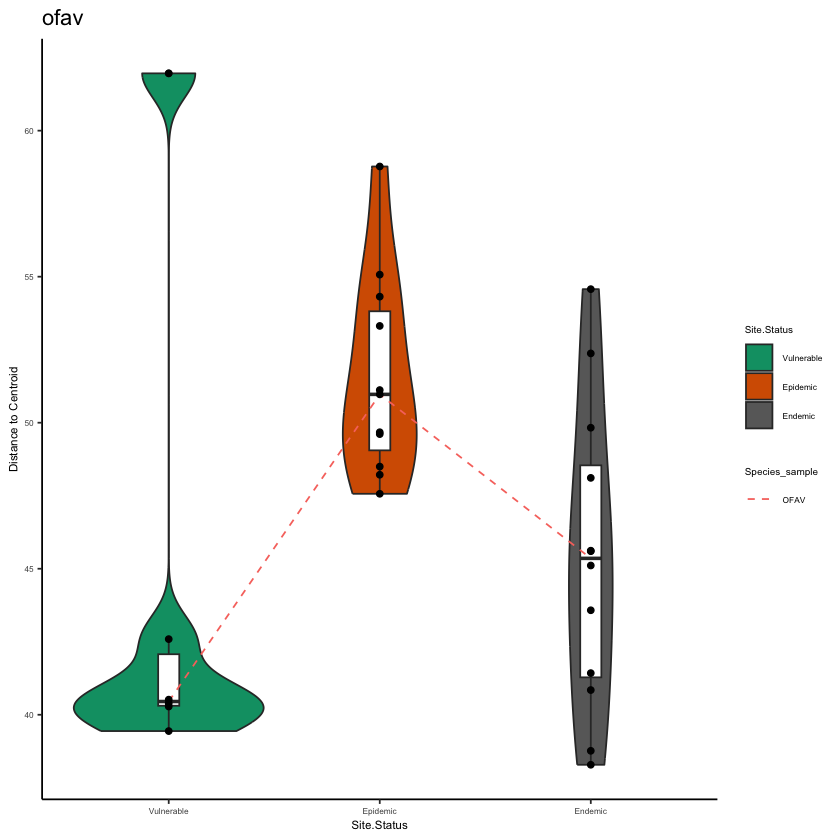

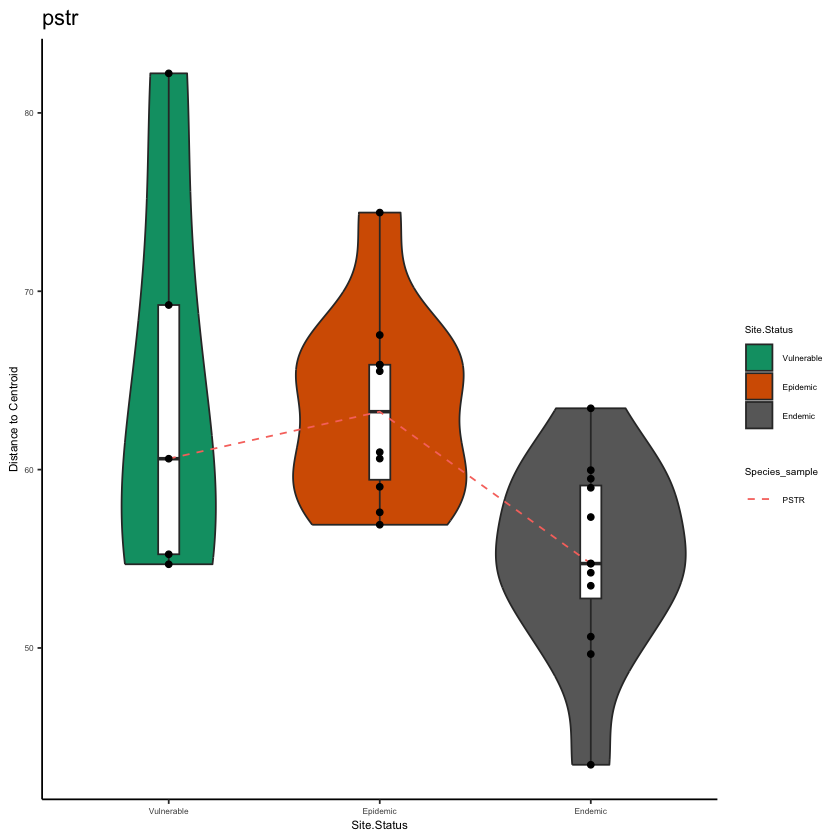

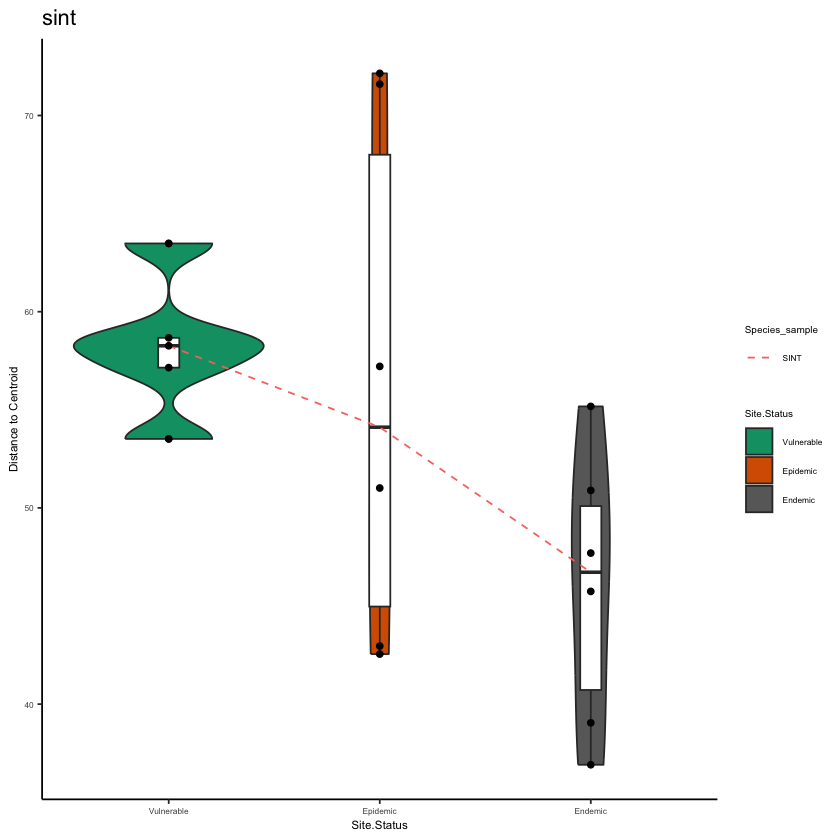

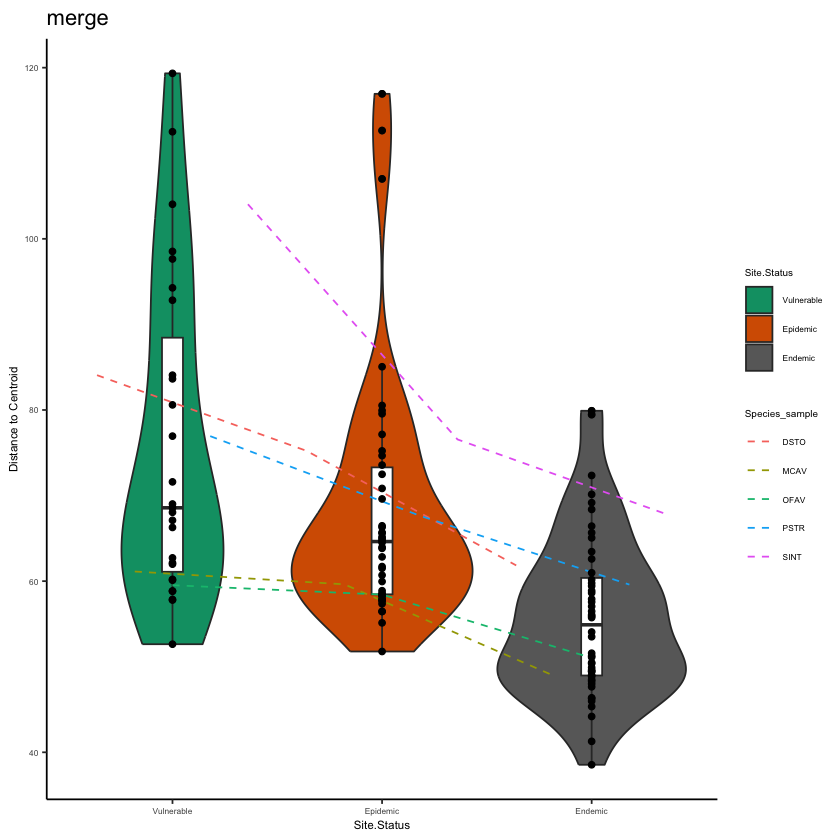

In [14]:
# List of datasets
datasets <- list(ps_clr_dsto, ps_clr_mcav, ps_clr_ofav, ps_clr_pstr, ps_clr_sint, ps_merge_clr)

# Loop through each dataset
for (i in seq_along(datasets)) {
  # Compute dissimilarity indices
  dis <- vegdist(otu_table(t(datasets[[i]])), method = "euclidean")
  
  # PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
  mod <- betadisper(dis, sample_data(datasets[[i]])$Site.Status)
  
  # Create dataframe of distances
  mod_dist <- as.data.frame(mod$distances)
  # Combine sample data with distances
  mod_dist_df <- cbind(sample_data(datasets[[i]]), mod_dist)
  
  # Assign unique labels
  unique_labels <- c("dsto", "mcav", "ofav", "pstr", "sint", "merge")
  #names(mod_dist_df) <- paste0(names(mod_dist_df), "_", unique_labels[i])
  
  # Plotting
  mod_dist_df$Site.Status <- factor(mod_dist_df$Site.Status, levels = c("Vulnerable", "Epidemic", "Endemic"))
  
  p <- ggplot(mod_dist_df,
              aes(x = Site.Status, y = mod$distances)) +  
    geom_violin(aes(fill = Site.Status)) +
   geom_boxplot(width=0.1)+
    stat_summary(
      fun.y = median,
      geom = 'line',
      linetype = "dashed",
      aes(group = Species_sample,
         color=Species_sample),  # Changed group aesthetic to Site.Status
      position = position_dodge(width = 0.9)
    ) +
    geom_point() +
    scale_fill_manual(values = cbPalette) +
    theme_linedraw() +
    theme_classic() +
    ylab("Distance to Centroid") +
    theme(legend.text = element_text(size = 5)) +
    theme(legend.title = element_text(size = 6)) +
    theme(axis.title.x = element_text(size = 7)) +
    theme(axis.title.y = element_text(size = 7)) +
    theme(axis.text.x = element_text(size = 5)) +
    theme(axis.text.y = element_text(size = 5)) +

    ggtitle(unique_labels[i])  # Adding a title to distinguish plots
  
  # Print the plot
  print(p)
}


In [15]:
# Load required libraries
library(vegan)

# Define the list of datasets with corresponding names
datasets <- list(dsto = ps_clr_dsto, 
                  mcav = ps_clr_mcav, 
                  ofav = ps_clr_ofav, 
                  pstr = ps_clr_pstr, 
                  sint = ps_clr_sint, 
                  merge = ps_merge_clr)

# Create a for loop to iterate over each dataset
for (name in names(datasets)) {
  # Compute dissimilarities
  dis <- vegdist(otu_table(t(datasets[[name]])), method = "euclidean")
  
  # Homogeneity of group dispersions
  mod <- betadisper(dis, sample_data(datasets[[name]])$Site.Status)
  
  # Permutation test for F
  tukey_test <- TukeyHSD(mod, pairwise = TRUE)
  
  # Print results
  cat("Dataset:", name, "\n")
  print(perm_test)
}

Dataset: dsto 


ERROR: Error in eval(expr, envir, enclos): object 'perm_test' not found


In [16]:
my_comparisons = list( c("Vulnerable", "Epidemic"), c("Vulnerable", "Endemic"), c("Endemic", "Epidemic") )

# compute dissimilarity indices
dis <- vegdist(otu_table(t(ps_merge_clr)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis, sample_data(ps_merge)$Site.Status)
mod
mod_dist= as.data.frame(mod$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_merge), mod_dist) 
head(mod_dist_df)



mod_dist_df$Site.Status <- factor(mod_dist_df$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))


disp_fig=ggplot(mod_dist_df,
       aes(x=Site.Status, y=mod$distances)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Species_sample, color=Species_sample)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
guides(group = guide_legend(order = 0),
         color  = guide_legend(order = 1)) +
geom_boxplot(width=0.1)+
geom_point() +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
#facet_wrap("Species_sample") +
theme_classic() +
ylab("Distance to Centroid") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
 theme(legend.key.height= unit(.2, 'cm'),
        legend.key.width= unit(.2, 'cm')) +
theme(axis.title.x = element_blank()) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_blank()) +
theme(axis.text.y = element_text(size =5)) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(119, 123.5, 130
                                                             ), aes(label = after_stat(p.signif)))

disp_fig


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = sample_data(ps_merge)$Site.Status)

No. of Positive Eigenvalues: 116
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     75.86      68.48      55.75 

Eigenvalues for PCoA axes:
(Showing 8 of 116 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
79101 42737 26972 20885 19128 15983 14841 13371 

[1] 117   1

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,1,0,0,0,0,0,0,0,0,84.06846
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,1,0,0,0,0,0,0,0,0,71.59936
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,1,0,0,0,0,0,0,0,0,94.27359
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,1,0,0,0,0,0,0,0,0,67.10831
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,1,0,0,0,0,0,0,0,0,92.82647
CG.DSTO.En1,CG.DSTO.En1_S6,CG.DSTO.En1_S6,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,79.45642


ERROR: Error in stat_compare_means(comparisons = my_comparisons, label.y = c(119, : could not find function "stat_compare_means"


In [17]:
ps_merge_clr_ord <- ordinate(ps_merge_clr, "RDA", "euclidean")

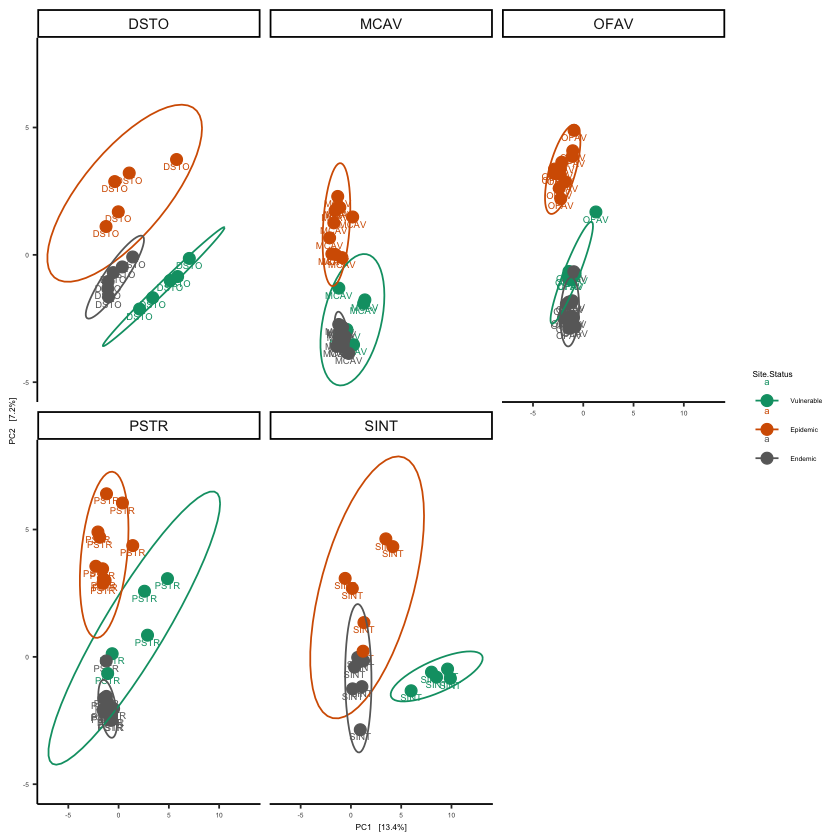

In [18]:
plot_ordination(ps_merge, ps_merge_clr_ord,
                               color="Site.Status",
                          
                label ="Species_sample",
                            axes = c(1,2)) +
geom_point(size = 3) +
scale_color_manual(values = cbPalette) +
#scale_shape_manual("Reef", values = c(3, 16, 18, 18)) +
#scale_color_manual(values = c("#274e13","#76a5af","#837dbe", "#ed8655" )) +
theme_classic() +
facet_wrap(.~Species_sample)+
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
theme(axis.text.y = element_text(size =4))+
stat_ellipse()

In [19]:
ps_merge_meta= data.frame(sample_data(ps_merge))
head(ps_merge_meta)
dim(ps_merge_meta)
#ps_ra_ad
#distances between
ps_veg_ad = dist(otu_table(t(ps_merge_clr)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Species_sample*Project*Site.Name*Date, 
       data =ps_merge_meta, 
         method = "euclidean", permutations = 999)



pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_merge)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")



,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
CG.DSTO.En1,CG.DSTO.En1_S6,CG.DSTO.En1_S6,NA,Cliff.Green,Lower Keys,EPA2,cor,Coral,DSTO,Healthy,⋯,0,0,1,0,0,0,0,0,0,0


[1] 117  32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,70057.784,0.11858367,10.424784,0.001
Species_sample,4,87704.404,0.14845331,6.525324,0.001
Project,1,21851.024,0.03698625,6.502981,0.001
Site.Name,1,7149.800,0.01210215,2.127819,0.004
Date,4,28109.157,0.04757911,2.091359,0.001
Site.Status:Species_sample,6,41517.234,0.07027436,2.059292,0.001
Species_sample:Site.Name,2,8311.164,0.01406793,1.236723,0.080
Species_sample:Date,4,16952.957,0.02869551,1.261323,0.036
Residual,92,309134.265,0.52325771,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,32268.53,7.464421,0.09276673,0.001,0.003,*
Vulnerable vs Epidemic,1,39161.65,7.136195,0.09625791,0.001,0.003,*
Endemic vs Epidemic,1,34160.74,8.392287,0.08706389,0.001,0.003,*


In [20]:
library(ggpubr)

# List of datasets and corresponding labels
datasets <- list(
  list(data = ps_clr_dsto, ord = ps_clr_dst_ord),
  list(data = ps_clr_sint, ord = ps_clr_sint_ord),
  list(data = ps_clr_mcav, ord = ps_clr_mcav_ord),
  list(data = ps_clr_pstr, ord = ps_clr_pstr_ord),
  list(data = ps_clr_ofav, ord = ps_clr_ofav_ord )
)

# Create a list to store plots
plots <- list()

# Loop through each dataset
for (i in seq_along(datasets)) {
  # Extracting dataset, ordination data, and label
  data <- datasets[[i]]$data
  ord <- datasets[[i]]$ord
  
  # Plotting ordination
  p <- plot_ordination(
    data, ord,
    color = "Site.Status",
    axes = c(1, 2)
  ) +

    geom_point(size = 3) +
    scale_color_manual(values = cbPalette) +
    theme_classic() +
    facet_wrap(Species_sample~.) +
     theme(strip.text = element_text(
    size = 7, face="bold")) +
    theme(legend.text = element_text(size = 4)) +
    theme(legend.title = element_text(size = 5)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 4)) +
    theme(axis.text.y = element_text(size = 4)) +
    stat_ellipse() +
    guides(fill = "none", color = "none", linetype = "none", shape = "none")
  
  # Add plot to the list
  plots[[i]] <- p
}

# Arrange plots using ggarrange
combined_plots <- ggarrange(disp_fig, plotlist =plots, nrow = 2, ncol=3, common.legend = TRUE,
                           labels = c(" a.", " b.", "c. ", "d. ", "e.", "f."))

# Print the combined plot
print(combined_plots)


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/beta_coral.png",
     width = 7, height = 7, units = "in", dpi=300)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:qiime2R’:

    mean_sd


The following object is masked from ‘package:microViz’:

    stat_chull




ERROR: Error in eval(expr, envir, enclos): object 'disp_fig' not found


## DSTO 

In [21]:
ps_clr_dst_meta= data.frame(sample_data(ps_clr_dsto))
head(ps_clr_dst_meta, n=2)
dim(ps_clr_dst_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_dsto)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Date*Project,
       data =ps_clr_dst_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_dsto)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

#pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_dsto)$Site.Name, sim.method = "euclidean",
 #               p.adjust.m = "bonferroni")

#pairwise.adonis(ps_veg_ad, phyloseq::sample_data()$Project, sim.method = "euclidean",
 #               p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,DSTO,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 16 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,25939.78,0.3369085,3.302569,0.001
Residual,13,51053.76,0.6630915,NA,NA
Total,15,76993.55,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,15778.139,4.367077,0.3267039,0.008,0.024,.
Vulnerable vs Epidemic,1,15872.074,3.590954,0.3098066,0.003,0.009,*
Endemic vs Epidemic,1,7523.294,1.978043,0.1801817,0.003,0.009,*


## OFAV

In [22]:
ps_clr_ofav_meta= data.frame(sample_data(ps_clr_ofav))
head(ps_clr_ofav_meta, n=2)
dim(ps_clr_ofav_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_ofav)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Project*Site.Name*Date,
       data =ps_clr_ofav_meta, 
         method = "euclidean", permutations = 999)

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_ofav)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_ofav)$Site.Name, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_ofav)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 29 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,18515.449,0.21829260,3.844249,0.001
Site.Name,1,3539.875,0.04173425,1.469925,0.031
Date,2,7375.461,0.08695488,1.531322,0.006
Residual,23,55388.622,0.65301827,NA,NA
Total,28,84819.406,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,9566.823,3.468819,0.1878203,0.001,0.003,*
Vulnerable vs Endemic,1,7305.515,3.162647,0.1650423,0.001,0.003,*
Epidemic vs Endemic,1,10557.076,4.084374,0.1628254,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Xesto.Patch vs Lindsays.Patch,1,3597.205,1.195788,0.04241016,0.151,0.151,


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SWG vs EPA2,1,7958.372,2.795644,0.09382726,0.001,0.001,**


## MCAV

In [23]:
ps_clr_mcav_meta= data.frame(sample_data(ps_clr_mcav))
head(ps_clr_mcav_meta, n=2)
dim(ps_clr_mcav_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_mcav)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Project*Site.Name*Date,
       data =ps_clr_mcav_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_mcav)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_mcav)$Site.Name, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_mcav)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
521.H,521.H_S18,521.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,MCAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
522.H,522.H_S18,522.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,MCAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 28 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,13941.027,0.21181945,3.764239,0.001
Site.Name,1,4087.915,0.06211163,2.207569,0.001
Date,3,8899.451,0.13521792,1.601970,0.002
Residual,21,38887.222,0.59085100,NA,NA
Total,27,65815.615,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,7505.778,3.070525,0.1798729,0.001,0.003,*
Vulnerable vs Endemic,1,5862.556,3.109849,0.1627354,0.001,0.003,*
Epidemic vs Endemic,1,7487.741,3.804340,0.1598171,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Xesto.Patch vs Lindsays.Patch,1,4087.915,1.721849,0.06211163,0.009,0.009,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SWG vs EPA2,1,6453.287,2.826463,0.09805099,0.001,0.001,**


## SINT

In [24]:
ps_clr_sint_meta= data.frame(sample_data(ps_clr_sint))
head(ps_clr_sint_meta, n=2)
dim(ps_clr_sint_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_sint)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Date*Project,
       data =ps_clr_sint_meta, 
         method = "euclidean", permutations = 999)

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_sint)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_sint)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C2,R3S7C2_S12,R3S7C2_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,Coral,SINT,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 17 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,31378.38,0.3880922,4.439633,0.001
Residual,14,49474.52,0.6119078,NA,NA
Total,16,80852.90,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,19554.405,5.901804,0.3960463,0.003,0.009,*
Vulnerable vs Epidemic,1,21878.509,5.374269,0.3738812,0.002,0.006,*
Endemic vs Epidemic,1,6472.537,1.992124,0.1661194,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EPA1 vs EPA2,1,24905.85,6.677522,0.308039,0.001,0.001,**


## PSTR

In [25]:
ps_clr_pstr_meta= data.frame(sample_data(ps_clr_pstr))
head(ps_clr_pstr_meta, n=2)
dim(ps_clr_pstr_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_pstr)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Date*Project*Site.Name,
       data =ps_clr_pstr_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_pstr)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_pstr)$Site.Name, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_pstr)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
527.H,527.H_S18,527.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,PSTR,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
528.H,528.H_S18,528.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,PSTR,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 27 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,23791.597,0.19509166,3.283008,0.001
Date,2,16747.787,0.13733226,2.311031,0.001
Site.Name,1,5319.129,0.04361698,1.467975,0.037
Residual,21,76092.351,0.62395910,NA,NA
Total,26,121950.864,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,13200.21,2.787774,0.1765780,0.001,0.003,*
Vulnerable vs Endemic,1,10924.00,2.840185,0.1592016,0.001,0.003,*
Epidemic vs Endemic,1,11757.36,3.051101,0.1323625,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Xesto.Patch vs Lindsays.Patch,1,6794.717,1.475109,0.05571684,0.02,0.02,.


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SWG vs EPA2,1,12034.23,2.737128,0.098681,0.001,0.001,**


In [26]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_fill_s = filter_taxa(ps_Sediment, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_s

ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")

ps_fill_w = filter_taxa(ps_Water, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_w

ps_clr_s <- microbiome::transform(ps_fill_s, 'clr')
psr_clr_ord_s <- ordinate(ps_clr_s, "RDA", "euclidean")


ps_clr_w <- microbiome::transform(ps_fill_w, 'clr')
psr_clr_ord_w <- ordinate(ps_clr_w, "RDA", "euclidean")


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4389 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 4389 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

## Sediment dispersion

In [27]:
# compute dissimilarity indices
dis_s <- vegdist(otu_table(t(ps_clr_s)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis_s, sample_data(ps_clr_s)$Site.Status)
mod
tukey_test <- TukeyHSD(mod, pairwise = TRUE)
tukey_test
mod_dist_s=as.data.frame(mod$distances)
dim(mod_dist_s)
mod_dist_df_s=cbind(sample_data(ps_clr_s), mod_dist_s) 
head(mod_dist_df_s)


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_s, group = sample_data(ps_clr_s)$Site.Status)

No. of Positive Eigenvalues: 89
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     89.34     110.97     111.04 

Eigenvalues for PCoA axes:
(Showing 8 of 89 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
166288 107797  45291  38744  26877  22627  19949  17072 

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                           diff       lwr       upr     p adj
Epidemic-Vulnerable 21.62772858 16.439087 26.816370 0.0000000
Endemic-Vulnerable  21.70298585 16.514344 26.891627 0.0000000
Endemic-Epidemic     0.07525727 -5.113384  5.263899 0.9993408


[1] 90  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,92.61484
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,93.94526
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,87.79212
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,86.61877
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,89.23114
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,93.05484


## Water dispersion

In [28]:
# compute dissimilarity indices
dis_w <- vegdist(otu_table(t(ps_clr_w)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis_w, sample_data(ps_clr_w)$Site.Status)
mod
tukey_test <- TukeyHSD(mod, pairwise = TRUE)
tukey_test
mod_dist_w=as.data.frame(mod$distances)
dim(mod_dist_w)
mod_dist_df_w=cbind(sample_data(ps_clr_w), mod_dist_w) 
head(mod_dist_df_w)


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_w, group = sample_data(ps_clr_w)$Site.Status)

No. of Positive Eigenvalues: 95
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     30.81      39.88      42.62 

Eigenvalues for PCoA axes:
(Showing 8 of 95 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
97770 28427 23827 10452  6850  4876  3714  3280 

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                         diff       lwr       upr     p adj
Epidemic-Vulnerable  9.069050  2.985111 15.152988 0.0017389
Endemic-Vulnerable  11.810855  5.726917 17.894794 0.0000359
Endemic-Epidemic     2.741805 -3.612661  9.096272 0.5613564


[1] 96  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,38.70039
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,23.62754
R3.11.W,R3.11.W_S14,R3.11.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,23.13442
R3.12.W,R3.12.W_S14,R3.12.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,20.16302
R3.13.W,R3.13.W_S14,R3.13.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,22.74236
R3.14.W,R3.14.W_S14,R3.14.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,21.75199


## Sediment PERMANOVA


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_s, group = sample_data(ps_clr_s)$Site.Status)

No. of Positive Eigenvalues: 89
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     89.34     110.97     111.04 

Eigenvalues for PCoA axes:
(Showing 8 of 89 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
166288 107797  45291  38744  26877  22627  19949  17072 

[1] 90  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod_s$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,92.61484
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,93.94526
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,87.79212
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,86.61877
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,89.23114
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,0,0,0,1,0,0,0,0,0,93.05484


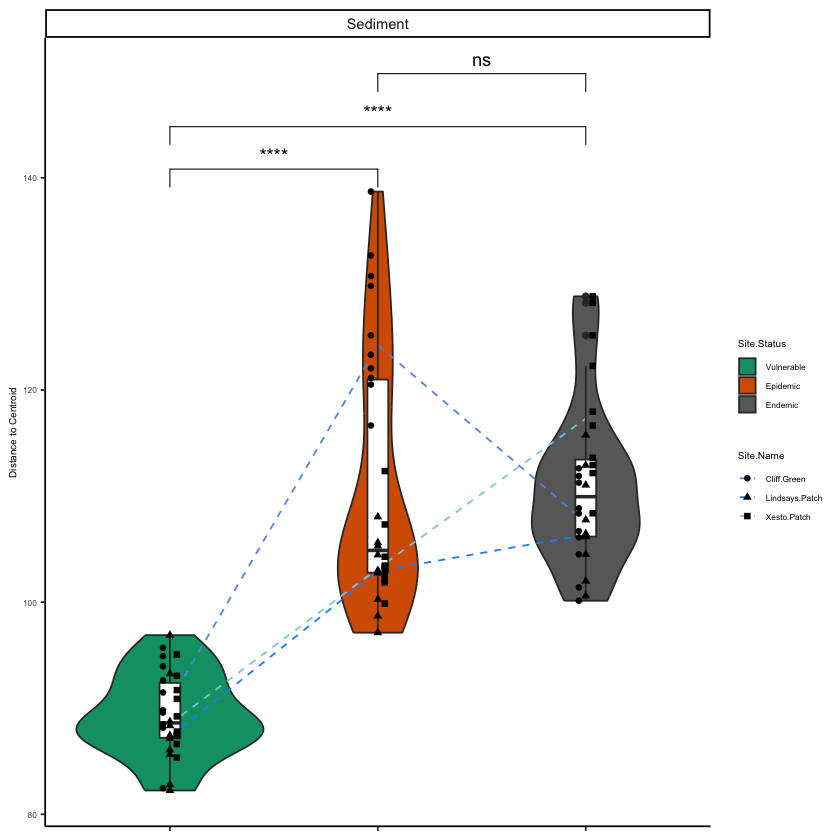

In [29]:
dis_s <- vegdist(otu_table(t(ps_clr_s)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_s<- betadisper(dis_s, sample_data(ps_clr_s)$Site.Status)
mod_s
mod_dist_s= as.data.frame(mod_s$distances)
dim(mod_dist_s)
mod_dist_df_s=cbind(sample_data(ps_clr_s), mod_dist_s) 
head(mod_dist_df_s)


disp_fig_s=ggplot(mod_dist_df_s,
       aes(x=Site.Status, y=mod_s$distances)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Site.Name, color=Site.Name)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
scale_color_manual(values=c( "#6495ED", "#1E90FF" ,"#87CEEB"
                          )) +
geom_boxplot(width=0.1)+
geom_point(aes(shape=Site.Name), position = position_dodge(width = .1)) +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
facet_grid(.~Type) +
theme_classic() +
ylab("Distance to Centroid") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
guides(group = guide_legend(order = 1),
         fill  = guide_legend(order = 0)) +
theme(axis.title.x = element_blank()) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_blank()) +
theme(axis.text.y = element_text(size =5)) +
 theme(legend.key.height= unit(.4, 'cm'),
        legend.key.width= unit(.4, 'cm')) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(138, 142, 147
                                                             ), aes(label = after_stat(p.signif)))
disp_fig_s


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = sample_data(ps_clr_w)$Site.Status)

No. of Positive Eigenvalues: 95
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     30.81      39.88      42.62 

Eigenvalues for PCoA axes:
(Showing 8 of 95 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
97770 28427 23827 10452  6850  4876  3714  3280 

[1] 96  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,38.70039
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,23.62754
R3.11.W,R3.11.W_S14,R3.11.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,23.13442
R3.12.W,R3.12.W_S14,R3.12.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,20.16302
R3.13.W,R3.13.W_S14,R3.13.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,22.74236
R3.14.W,R3.14.W_S14,R3.14.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,water,Water,Water,NA,⋯,0,0,0,0,0,0,1,0,0,21.75199


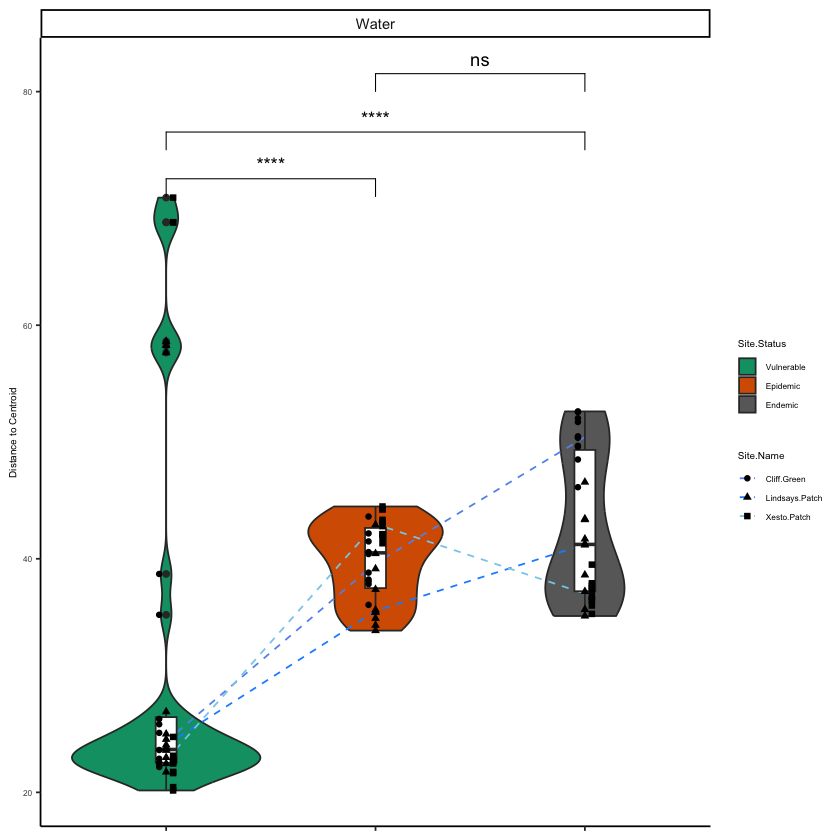

In [30]:
dis <- vegdist(otu_table(t(ps_clr_w)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis, sample_data(ps_clr_w)$Site.Status)
mod
mod_dist= as.data.frame(mod$distances)
dim(mod_dist)
mod_dist_df_w=cbind(sample_data(ps_clr_w), mod_dist) 
head(mod_dist_df_w)


disp_fig_w=ggplot(mod_dist_df_w,
       aes(x=Site.Status, y=mod$distances)) +
geom_violin(aes(fill=Site.Status)) +
stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Site.Name, color=Site.Name)
    #position = position_dodge(width = 0.9)  #this has to be added
  ) +
scale_color_manual(values=c( "#6495ED", "#1E90FF" ,"#87CEEB"
                          )) +
geom_boxplot(width=0.1)+
geom_point(aes(shape=Site.Name), position = position_dodge(width = .1)) +
scale_fill_manual(values = cbPalette) +
theme_linedraw() +
facet_grid(.~Type) +
theme_classic() +
ylab("Distance to Centroid") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
guides(group = guide_legend(order = 1),
         fill  = guide_legend(order = 0)) +
theme(axis.title.x = element_blank()) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_blank()) +
theme(axis.text.y = element_text(size =5)) +
 theme(legend.key.height= unit(.4, 'cm'),
        legend.key.width= unit(.4, 'cm')) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(70, 74, 79
                                                             ), aes(label = after_stat(p.signif)))
disp_fig_w

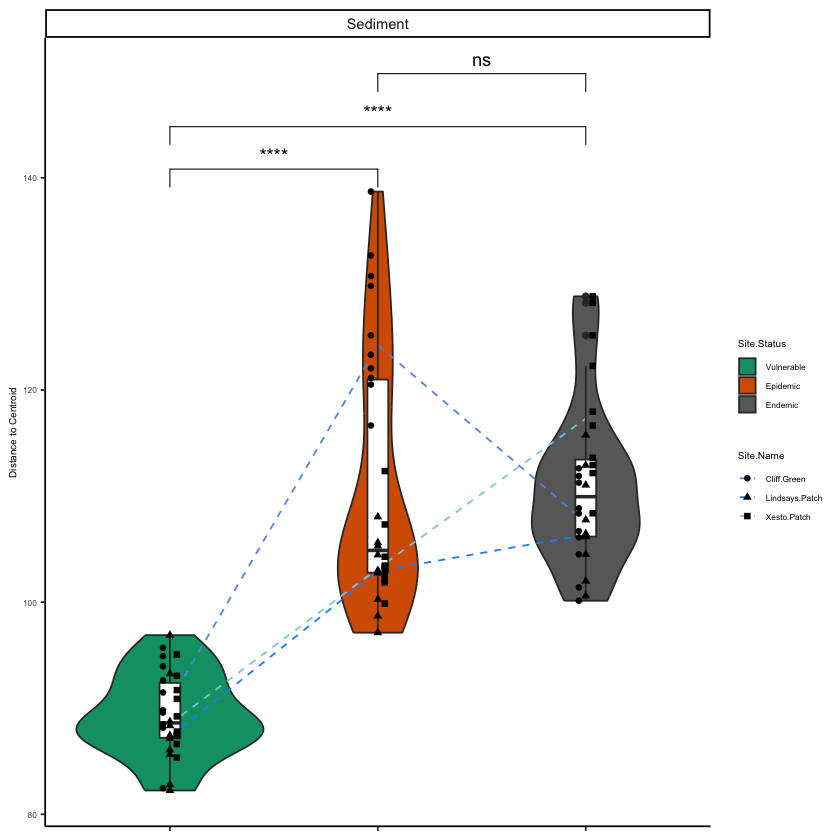

In [31]:
disp_fig_s

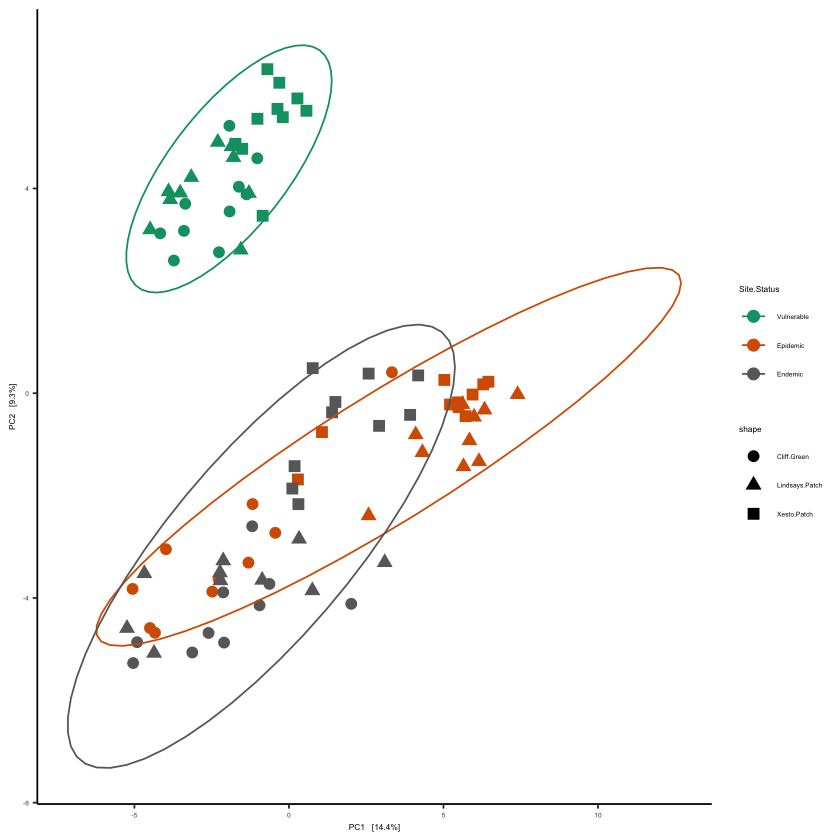

In [32]:
ord_s= plot_ordination(ps_clr_s,
    psr_clr_ord_s,
    color = "Site.Status",
    axes = c(1, 2)
  ) +

    geom_point(size = 3, aes(shape=Site.Name)) +
    scale_color_manual(values = cbPalette) +
    theme_classic() +
    #facet_wrap(. ~ Species_sample) +
    theme(legend.text = element_text(size = 4)) +
    theme(legend.title = element_text(size = 5)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 4)) +
    theme(axis.text.y = element_text(size = 4)) +
    stat_ellipse() #+
    #guides(fill = "none", color = "none", linetype = "none", shape = "none")
ord_s

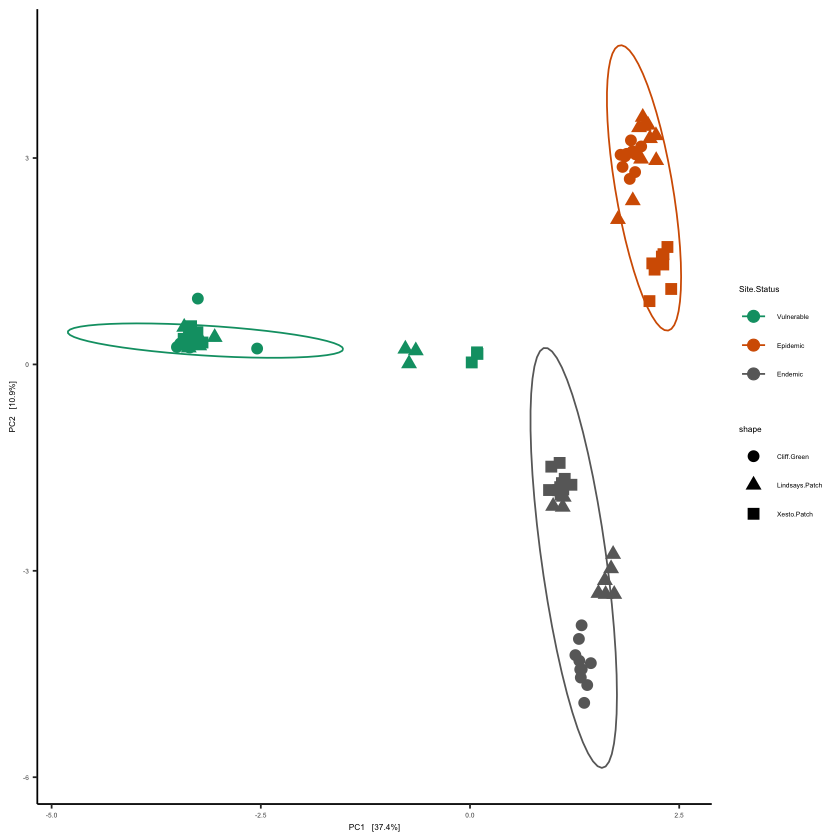

In [33]:
ord_w = plot_ordination(ps_clr_w,
    psr_clr_ord_w,
    color = "Site.Status",
    axes = c(1, 2)
  ) +

    geom_point(size = 3, aes(shape=Site.Name)) +
    scale_color_manual(values = cbPalette) +
    theme_classic() +
    #facet_wrap(. ~ Species_sample) +
    theme(legend.text = element_text(size = 4)) +
    theme(legend.title = element_text(size = 5)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 4)) +
    theme(axis.text.y = element_text(size = 4)) +
    stat_ellipse() #+
    #guides(fill = "none", color = "none", linetype = "none", shape = "none")
ord_w

In [ ]:
?ggarrange

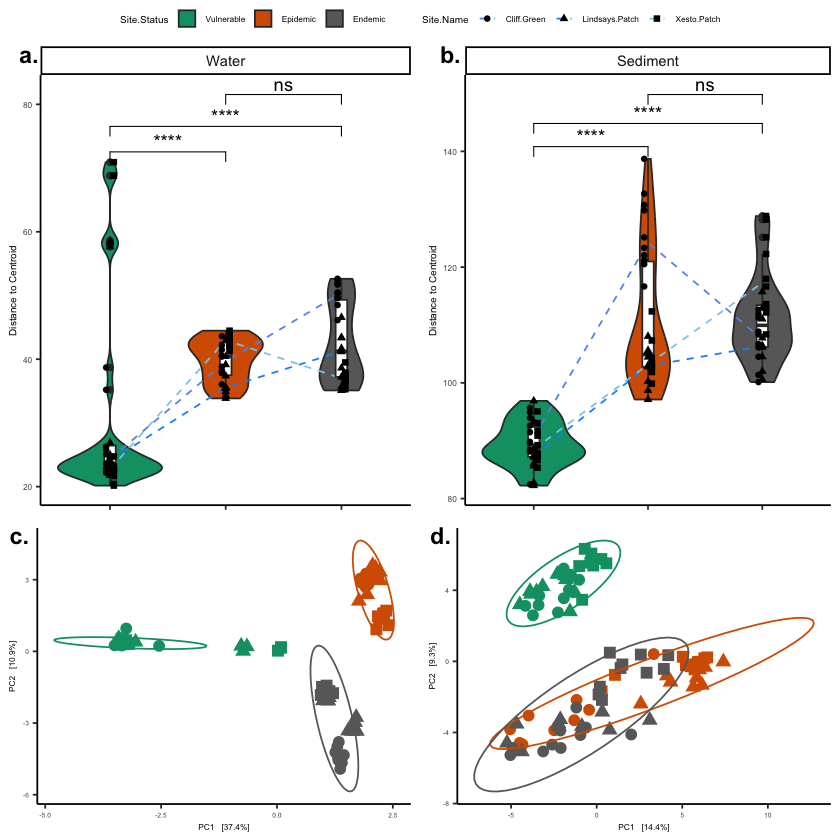

In [34]:
ggarrange(disp_fig_w, disp_fig_s, ord_w, ord_s, nrow = 2, ncol=2, common.legend = TRUE, heights=c(1.5,1),
                           labels = c(" a.", " b.", "c.", "d."))

#ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/beta_sed_water.png",
 #    width = 5, height = 7, units = "in", dpi=300)

In [35]:
ps_clr_s_meta= data.frame(sample_data(ps_clr_s))
head(ps_clr_s_meta, n=2)
dim(ps_clr_s_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_s)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Project*Site.Name*Date,
       data =ps_clr_s_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_s)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_s)$Site.Name, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_s)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,sed,Sediment,Sediment,NA,⋯,3,0,0,0,1,0,0,0,0,0


[1] 90 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,170910.10,0.14796799,8.653929,0.001
Site.Name,2,90826.54,0.07863444,4.598947,0.001
Date,2,33445.16,0.02895565,1.693475,0.005
Site.Status:Site.Name,3,69889.11,0.06050754,2.359195,0.001
Residual,80,789976.91,0.68393438,NA,NA
Total,89,1155047.82,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,106701.40,10.101532,0.14833046,0.001,0.003,*
Vulnerable vs Endemic,1,90889.86,8.622596,0.12942449,0.001,0.003,*
Epidemic vs Endemic,1,58773.89,4.580260,0.07319018,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cliff.Green vs Xesto.Patch,1,69940.23,5.841762,0.09150377,0.001,0.003,*
Cliff.Green vs Lindsays.Patch,1,34489.73,2.800962,0.04606772,0.002,0.006,*
Xesto.Patch vs Lindsays.Patch,1,31809.86,2.562976,0.04231918,0.002,0.006,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EPA1 vs EPA2,1,112136.2,9.461959,0.09708361,0.001,0.001,**


In [36]:
ps_clr_w_meta= data.frame(sample_data(ps_clr_w))
head(ps_clr_w_meta, n=2)
dim(ps_clr_w_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_w)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Project*Site.Name*Date,
       data =ps_clr_w_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_w)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_w)$Site.Name, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_w)$Project, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,water,Water,Water,NA,⋯,2,0,0,0,0,0,0,1,0,0


[1] 96 32

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Site.Status,2,116663.160,0.44645305,56.679290,0.001
Project,1,17287.688,0.06615748,16.798000,0.001
Site.Name,2,7775.312,0.02975499,3.777535,0.003
Date,3,21524.267,0.08237026,6.971525,0.001
Site.Status:Site.Name,3,11611.992,0.04443742,3.761024,0.001
Residual,84,86448.732,0.33082680,NA,NA
Total,95,261311.151,1.00000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,80042.64,57.32746,0.4725019,0.001,0.003,*
Vulnerable vs Endemic,1,63595.48,42.11177,0.3968624,0.001,0.003,*
Epidemic vs Endemic,1,28659.13,16.09336,0.2172038,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cliff.Green vs Xesto.Patch,1,4618.262,1.662517,0.02653128,0.122,0.366,
Cliff.Green vs Lindsays.Patch,1,4018.194,1.454266,0.02328529,0.170,0.510,
Xesto.Patch vs Lindsays.Patch,1,2949.014,1.115227,0.01712697,0.299,0.897,


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EPA1 vs SWG,1,17287.69,24.416025,0.41796793,0.001,0.003,*
EPA1 vs EPA2,1,95605.17,56.284087,0.39009213,0.001,0.003,*
SWG vs EPA2,1,13351.25,6.170114,0.08793079,0.001,0.003,*
